In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [200]:
# df = pd.read_excel('/content/drive/My Drive/datecrime.xlsx',index_col='Date',parse_dates=True)
# del df["days_from_start"]

data = pd.read_excel('/content/drive/My Drive/MOPAC/Crime/Borough Daily 2018-20.xlsx')
data2021 = pd.read_excel('/content/drive/My Drive/MOPAC/Crime/Borough Daily Data 2021.xlsx')

df = pd.concat([data, data2021])
data = df
data = data.fillna(data.mean())
data = data.rename(columns={'Date - Daily Data': 'date'})
# data = data.rename(columns={'Month-Year': 'date'})
data = data.groupby(by="date").sum()

df = data["TNO Offs"].to_frame()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  if __name__ == '__main__':


In [201]:
df

,TNO Offs
date,
2018-01-01,2098.0
2018-01-02,1973.0
2018-01-03,2353.0
2018-01-04,2234.0
2018-01-05,2224.0
...,...
2021-06-26,2218.0
2021-06-27,2039.0
2021-06-28,2346.0


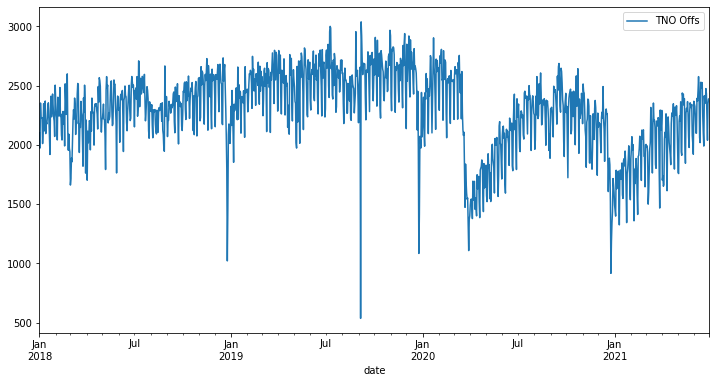

In [202]:
df.plot(figsize=(12,6))

In [203]:
from statsmodels.tsa.seasonal import seasonal_decompose

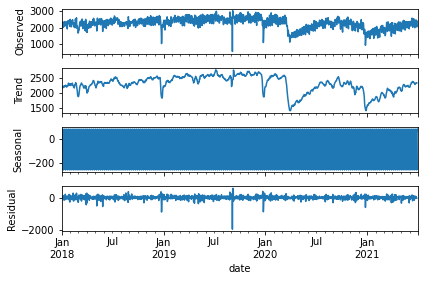

In [204]:
results = seasonal_decompose(df['TNO Offs'])
results.plot();

In [205]:
len(df)

1277

In [206]:
size = int(len(df)*0.8)
train = df.iloc[:size]
test = df.iloc[size:]

In [207]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [208]:
df.head(),df.tail()

(            TNO Offs
 date                
 2018-01-01    2098.0
 2018-01-02    1973.0
 2018-01-03    2353.0
 2018-01-04    2234.0
 2018-01-05    2224.0,             TNO Offs
 date                
 2021-06-26    2218.0
 2021-06-27    2039.0
 2021-06-28    2346.0
 2021-06-29    2388.0
 2021-06-30    2387.0)

In [209]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [210]:
scaled_train[:10]

array([[0.62430056],
       [0.57434053],
       [0.72621902],
       [0.67865707],
       [0.67466027],
       [0.67705835],
       [0.58952838],
       [0.63349321],
       [0.72422062],
       [0.63189448]])

In [211]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [212]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [213]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.62430056 0.57434053 0.72621902]
Predict this y: 
 [[0.67865707]]


In [214]:
X.shape

(1, 3, 1)

In [215]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [216]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [217]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [218]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [219]:
# fit model
model.fit(generator,epochs= 35)

Epoch 1/35
1009/1009 [==============================] - 8s 6ms/step - loss: 0.0361
Epoch 2/35
1009/1009 [==============================] - 6s 6ms/step - loss: 0.0108
Epoch 3/35
1009/1009 [==============================] - 6s 6ms/step - loss: 0.0078
Epoch 4/35
1009/1009 [==============================] - 6s 6ms/step - loss: 0.0076
Epoch 5/35
1009/1009 [==============================] - 6s 6ms/step - loss: 0.0077
Epoch 6/35
1009/1009 [==============================] - 6s 6ms/step - loss: 0.0064
Epoch 7/35
1009/1009 [==============================] - 6s 6ms/step - loss: 0.0088
Epoch 8/35
1009/1009 [==============================] - 6s 6ms/step - loss: 0.0076
Epoch 9/35
1009/1009 [==============================] - 6s 6ms/step - loss: 0.0076
Epoch 10/35
1009/1009 [==============================] - 6s 6ms/step - loss: 0.0066
Epoch 11/35
1009/1009 [==============================] - 6s 6ms/step - loss: 0.0077
Epoch 12/35
1009/1009 [==============================] - 6s 6ms/step - loss: 0.0069
E

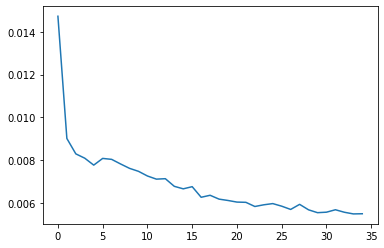

In [220]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [221]:
last_train_batch = scaled_train[-12:]

In [222]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [223]:
model.predict(last_train_batch)

array([[0.6441122]], dtype=float32)

In [224]:
scaled_test[0]

array([0.58553157])

In [225]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [226]:
test_predictions

[array([0.6441122], dtype=float32),
 array([0.7103596], dtype=float32),
 array([0.7021277], dtype=float32),
 array([0.68061566], dtype=float32),
 array([0.65214133], dtype=float32),
 array([0.62147975], dtype=float32),
 array([0.6335956], dtype=float32),
 array([0.6555098], dtype=float32),
 array([0.6429038], dtype=float32),
 array([0.6241689], dtype=float32),
 array([0.60448635], dtype=float32),
 array([0.6035992], dtype=float32),
 array([0.6180862], dtype=float32),
 array([0.61267006], dtype=float32),
 array([0.6003603], dtype=float32),
 array([0.586395], dtype=float32),
 array([0.5852469], dtype=float32),
 array([0.5932543], dtype=float32),
 array([0.5916526], dtype=float32),
 array([0.5815015], dtype=float32),
 array([0.57160616], dtype=float32),
 array([0.57191885], dtype=float32),
 array([0.57711744], dtype=float32),
 array([0.57578886], dtype=float32),
 array([0.56759536], dtype=float32),
 array([0.561621], dtype=float32),
 array([0.56254625], dtype=float32),
 array([0.56606054]

In [227]:
test.head()

,TNO Offs
date,
2020-10-18,2001.0
2020-10-19,2397.0
2020-10-20,2582.0
2020-10-21,2326.0
2020-10-22,2466.0


In [228]:
true_predictions = scaler.inverse_transform(test_predictions)

In [229]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


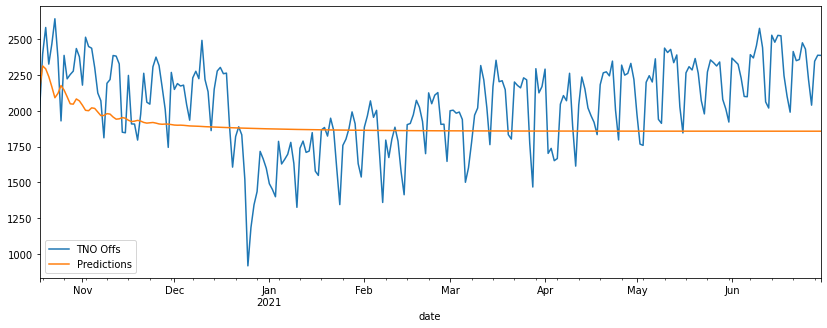

In [230]:
test.plot(figsize=(14,5))

In [231]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
rmse=sqrt(mean_squared_error(test['TNO Offs'],test['Predictions']))
print(test["TNO Offs"].mean())
print(rmse)
print(r2_score(test['TNO Offs'],test['Predictions']))

2043.09765625
327.37063704290773
-0.20262593889932967
